Some codes like model definition, data cleaning, and train-test splitting is repeated across the different models. I intentionally included it separately within each model so that every model would be self-contained and runnable independently, without relying on other models.

###Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import re
import numpy as np
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

###Load the data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
filepath = '/content/gdrive/MyDrive/emotional_quotes_categorized.xlsx'
data = pd.read_excel(filepath)

In [5]:

print(data.shape)

(895, 3)


In [6]:
data

,Quote,Category,Category_number
0,זעקה שוברת לב של אמא של עומר אשר נחטף לעזה: ‘א...,נחישות,2
1,לא אתן שישתיקו זעקה כואבת בשם ‘אחדות מדומיינת’...,נחישות,2
2,במכתב נוקב לרמטכ״ל דורש ‘פורום הגבורה’: להמשיך...,נחישות,2
3,סא״ל שלום אייזנר נפצע בפעילות ברצועה; בני המשפ...,כאב,1
4,הביאו גופות מעזה… ‘של נאצים או חטפים? לצערי הפ...,כאב,1
...,...,...,...
890,"הלוויתו של סמ""ר זמיר בורק הי""ד שנפל בעזה תתקיי...",כאב,1
891,"סמ""ר זמיר בורק, בן 20 מבית שמש, נהרג מפגיעת טי...",כאב,1
892,הבית הלבן על הסרטון של עידן אלכסנדר: תזכורת לט...,כאב,1
893,"דיווחים בלבנון: ירי ארטילרי לדרום המדינה, כטב""...",נחישות,2


In [7]:

df=data
df = df.rename(columns={
    df.columns[0]: 'Title',
    df.columns[1]: 'CategoryHebrew',
    df.columns[2]: 'Label'
})

In [8]:
df

,Title,CategoryHebrew,Label
0,זעקה שוברת לב של אמא של עומר אשר נחטף לעזה: ‘א...,נחישות,2
1,לא אתן שישתיקו זעקה כואבת בשם ‘אחדות מדומיינת’...,נחישות,2
2,במכתב נוקב לרמטכ״ל דורש ‘פורום הגבורה’: להמשיך...,נחישות,2
3,סא״ל שלום אייזנר נפצע בפעילות ברצועה; בני המשפ...,כאב,1
4,הביאו גופות מעזה… ‘של נאצים או חטפים? לצערי הפ...,כאב,1
...,...,...,...
890,"הלוויתו של סמ""ר זמיר בורק הי""ד שנפל בעזה תתקיי...",כאב,1
891,"סמ""ר זמיר בורק, בן 20 מבית שמש, נהרג מפגיעת טי...",כאב,1
892,הבית הלבן על הסרטון של עידן אלכסנדר: תזכורת לט...,כאב,1
893,"דיווחים בלבנון: ירי ארטילרי לדרום המדינה, כטב""...",נחישות,2


###Distribution

'Label Distribution Table'

,Count,count
0,0,289
1,1,298
2,2,308


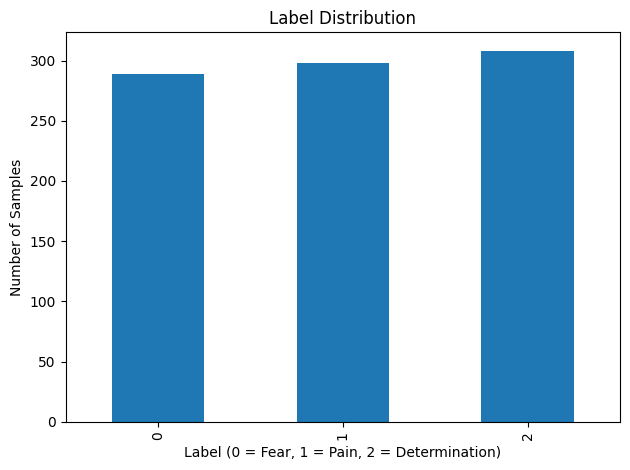

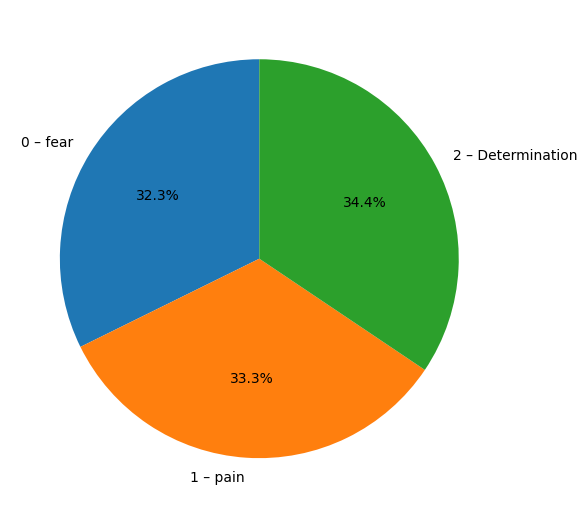

In [48]:
# Compute label distribution
label_counts = df['Label'].value_counts().sort_index()
# Display distribution table
display(
    'Label Distribution Table',
    label_counts.reset_index().rename(columns={'index': 'Label', 'Label': 'Count'})
)

# Plot distribution in English
plt.figure()
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label (0 = Fear, 1 = Pain, 2 = Determination)')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()



# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=['0 – fear', '1 – pain', '2 – Determination'], autopct='%1.1f%%', startangle=90)
plt.tight_layout()
plt.show()

###AlephBert embedding

In [8]:
# This cell loads the AlephBERT tokenizer and model,
# and defines a function to extract sentence-level embeddings using the [CLS] token.

tokenizer = AutoTokenizer.from_pretrained("onlplab/alephbert-base")  # Load pretrained tokenizer for AlephBERT
heb_model = AutoModel.from_pretrained("onlplab/alephbert-base")      # Load pretrained AlephBERT model

def get_hebert_embeddings(texts, max_length=128):
   '''
    Given a list of Hebrew text strings, returns AlephBERT embeddings
    based on the [CLS] token of each sentence.

    Args:
        texts (list of str): List of input sentences in Hebrew.
        max_length (int): Maximum token length for truncation/padding.

    Returns:
        torch.Tensor: A tensor of shape (batch_size, hidden_dim) containing the [CLS] embeddings.
    '''
    # Tokenize the input texts with padding and truncation
    enc = tokenizer(
        texts,
        padding='max_length',     # Pad all sequences to the same length
        truncation=True,          # Truncate sequences longer than max_length
        max_length=max_length,    # Maximum sequence length
        return_tensors='pt'       # Return PyTorch tensors
    )

    # Disable gradient tracking during inference for efficiency
    with torch.no_grad():
        out = heb_model(**enc)

    # Return the embeddings of the [CLS] token (first token in each sequence)
    return out.last_hidden_state[:, 0, :]  # shape: (batch_size, hidden_dim)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# This cell demonstrates how to extract AlephBERT embeddings for Hebrew text samples,
# inspect the embedding vectors, and compute cosine similarity between sentence embeddings.

import torch

# 1. Select a few of your actual examples from the dataset
samples = df['Title'].iloc[:5].tolist()  # Take the first 5 titles from the dataframe

# 2. Compute embeddings for these samples using the previously defined function
embs = get_hebert_embeddings(samples, max_length=64)  # Resulting shape: (5, hidden_dim)

# 3. Inspect the shape and first few dimensions of each embedding
print("Embeddings shape:", embs.shape)  # Expected output: (5, 768) for AlephBERT
for i, txt in enumerate(samples):
    print(f"\nSample {i}:", txt)
    print("First 5 dims:", embs[i][:5].tolist())  # Print first 5 values of the embedding vector

# 4. Check cosine similarity for two identical inputs to validate embedding consistency
identical = [samples[0], samples[0]]  # Repeat the first sample twice
emb_same = get_hebert_embeddings(identical, max_length=64)
sim_same = torch.nn.functional.cosine_similarity(
    emb_same[0].unsqueeze(0),  # Add batch dimension
    emb_same[1].unsqueeze(0),
    dim=1
)
print(f"\nCosine similarity (identical inputs): {sim_same.item():.4f}")  # Expect close to 1.0

# 5. Check cosine similarity between sample 0 and sample 4 to assess semantic similarity
sim01 = torch.nn.functional.cosine_similarity(
    embs[0].unsqueeze(0),
    embs[4].unsqueeze(0),
    dim=1
)
print(f"Cosine similarity (sample 0 vs 3): {sim01.item():.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

Embeddings shape: torch.Size([5, 768])

Sample 0: זעקה שוברת לב של אמא של עומר אשר נחטף לעזה: ‘אין שמאל ואין ימין — אנחנו כולנו אחים, די ! תתאחדו!’
First 5 dims: [-0.6641746759414673, -0.8512203693389893, -0.21894079446792603, -0.9101003408432007, 0.03425317257642746]

Sample 1: לא אתן שישתיקו זעקה כואבת בשם ‘אחדות מדומיינת’ בזמן שחיילים נהרגים, חטופים נשכחים...
First 5 dims: [-0.6673517823219299, -0.19166044890880585, 0.0728359967470169, -0.4590515196323395, -0.47691255807876587]

Sample 2: במכתב נוקב לרמטכ״ל דורש ‘פורום הגבורה’: להמשיך בלחימה עד ניצחון מוחלט...
First 5 dims: [0.4957144260406494, -0.37168049812316895, -0.43961259722709656, 0.3479945957660675, -0.4496697187423706]

Sample 3: סא״ל שלום אייזנר נפצע בפעילות ברצועה; בני המשפחה מבקשים להתפלל לשלומו...
First 5 dims: [0.5887554287910461, -0.7722406983375549, -0.6481602191925049, -0.3855225443840027, -0.010682872496545315]

Sample 4: הביאו גופות מעזה… ‘של נאצים או חטפים? לצערי הפעם לא חטופים’
First 5 dims: [-0.6502819061279297

In [ ]:
# This cell calculates cosine similarity scores between random pairs of sentence embeddings,
# in order to understand the overall similarity distribution in the dataset.

import random

# Assume 'embs' is a tensor of shape (N, D) containing AlephBERT embeddings for all input titles
embs = get_hebert_embeddings(df['Title'].tolist(), max_length=64)

# Compute cosine similarity between M random pairs of embeddings
def random_pair_sims(embs, M=100):
    """
    Calculates cosine similarities between M randomly chosen pairs of embeddings.

    Args:
        embs (torch.Tensor): A tensor of shape (N, D), where N is the number of samples
        M (int): Number of random pairs to compare

    Returns:
        list of float: Cosine similarity values for the sampled pairs
    """
    sims = []
    N = embs.size(0)  # Number of embeddings
    for _ in range(M):
        i, j = random.sample(range(N), 2)  # Select two different random indices
        sim = torch.nn.functional.cosine_similarity(
            embs[i].unsqueeze(0),  # Add batch dimension for shape compatibility
            embs[j].unsqueeze(0),
            dim=1
        ).item()  # Convert tensor to scalar float
        sims.append(sim)
    return sims

# Compute similarities for 200 random pairs
sims = random_pair_sims(embs, M=200)

# Print basic statistics about the similarities
print("Min sim:", min(sims))                    # Minimum similarity across random pairs
print("Max sim:", max(sims))                    # Maximum similarity across random pairs
print("Mean sim:", sum(sims)/len(sims))         # Average similarity (expected: low/moderate)


Min sim: 0.6749734282493591
Max sim: 0.923673152923584
Mean sim: 0.7848407498002052


###MLP

In [10]:
def minimal_clean(text):
    text = str(text).lower()
    return re.sub(r'http\S+|www\.\S+', '', text).strip()

df['CleanTitle'] = df['Title'].apply(minimal_clean)
df

,Title,CategoryHebrew,Label,CleanTitle
0,זעקה שוברת לב של אמא של עומר אשר נחטף לעזה: ‘א...,נחישות,2,זעקה שוברת לב של אמא של עומר אשר נחטף לעזה: ‘א...
1,לא אתן שישתיקו זעקה כואבת בשם ‘אחדות מדומיינת’...,נחישות,2,לא אתן שישתיקו זעקה כואבת בשם ‘אחדות מדומיינת’...
2,במכתב נוקב לרמטכ״ל דורש ‘פורום הגבורה’: להמשיך...,נחישות,2,במכתב נוקב לרמטכ״ל דורש ‘פורום הגבורה’: להמשיך...
3,סא״ל שלום אייזנר נפצע בפעילות ברצועה; בני המשפ...,כאב,1,סא״ל שלום אייזנר נפצע בפעילות ברצועה; בני המשפ...
4,הביאו גופות מעזה… ‘של נאצים או חטפים? לצערי הפ...,כאב,1,הביאו גופות מעזה… ‘של נאצים או חטפים? לצערי הפ...
...,...,...,...,...
890,"הלוויתו של סמ""ר זמיר בורק הי""ד שנפל בעזה תתקיי...",כאב,1,"הלוויתו של סמ""ר זמיר בורק הי""ד שנפל בעזה תתקיי..."
891,"סמ""ר זמיר בורק, בן 20 מבית שמש, נהרג מפגיעת טי...",כאב,1,"סמ""ר זמיר בורק, בן 20 מבית שמש, נהרג מפגיעת טי..."
892,הבית הלבן על הסרטון של עידן אלכסנדר: תזכורת לט...,כאב,1,הבית הלבן על הסרטון של עידן אלכסנדר: תזכורת לט...
893,"דיווחים בלבנון: ירי ארטילרי לדרום המדינה, כטב""...",נחישות,2,"דיווחים בלבנון: ירי ארטילרי לדרום המדינה, כטב""..."


In [11]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    df['CleanTitle'], df['Label'],
    test_size=0.25, random_state=42, stratify=df['Label']
)

In [12]:
# This cell encodes the training and test text samples into AlephBERT embeddings,
# and converts the resulting PyTorch tensors to NumPy arrays for use with scikit-learn models.

import torch

texts_train = X_train.tolist()  # Convert training titles to list of strings
texts_test  = X_test.tolist()   # Convert test titles to list of strings

# Compute embeddings without tracking gradients (inference mode)
with torch.no_grad():
    train_embs = get_hebert_embeddings(texts_train).cpu().numpy()  # Convert to NumPy array
    test_embs  = get_hebert_embeddings(texts_test).cpu().numpy()   # Convert to NumPy array


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [13]:
import tensorflow as tf

input_dim = train_embs.shape[1]  # Dimensionality of the AlephBERT embeddings

# Define a simple feedforward neural network for classification
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),        # Input layer matching the embedding size
    tf.keras.layers.Dense(256, activation='relu'),    # Hidden layer with ReLU activation
    tf.keras.layers.Dropout(0.3),                     # Dropout for regularization
    tf.keras.layers.Dense(3, activation='softmax')    # Output layer for 3-class classification
])

model.summary()  # Print model architecture


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,635 (772.01 KB)

 Trainable params: 197,635 (772.01 KB)

 Non-trainable params: 0 (0.00 B)

very high overfitting

In [14]:
# Compile the model with Adam optimizer and suitable loss for integer labels
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),           # Learning rate = 0.001
    loss='sparse_categorical_crossentropy',             # Use sparse loss for integer class labels
    metrics=['accuracy']                                # Track accuracy during training
)

# Train the model for 10 epochs with validation
history = model.fit(
    train_embs, y_train.values,
    validation_data=(test_embs, y_test.values),
    epochs=10,
    batch_size=16
)


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5669 - loss: 1.0004 - val_accuracy: 0.7098 - val_loss: 0.6954
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8030 - loss: 0.4977 - val_accuracy: 0.7589 - val_loss: 0.6557
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8279 - loss: 0.4347 - val_accuracy: 0.7366 - val_loss: 0.6930
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8657 - loss: 0.3448 - val_accuracy: 0.7545 - val_loss: 0.6325
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8828 - loss: 0.3187 - val_accuracy: 0.7411 - val_loss: 0.6749
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9304 - loss: 0.2165 - val_accuracy: 0.7768 - val_loss: 0.6599
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9519 - loss: 0.1877 - val_accuracy: 0.7500 - val_loss: 0.7490
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9371 - loss: 0.1838 - val_accuracy: 0.7321 - val_loss

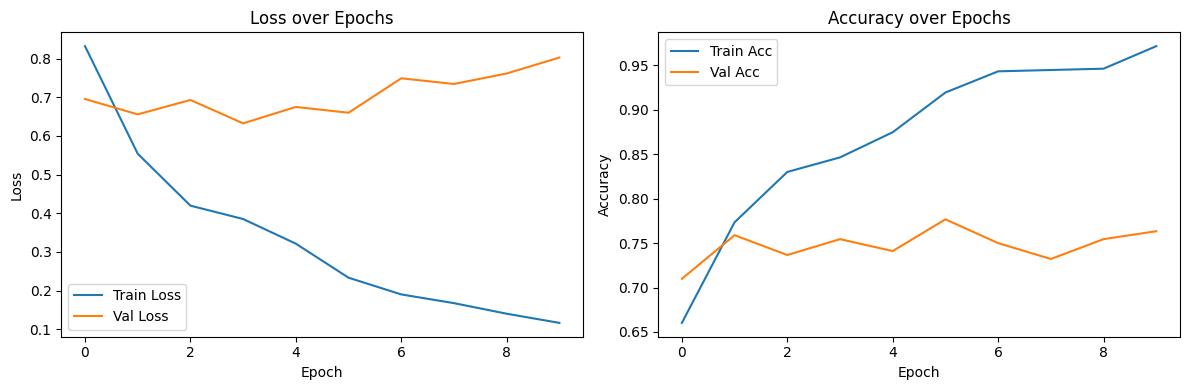

In [15]:
# Cell 5: Plot history
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.3700 - loss: 1.6297 - val_accuracy: 0.5268 - val_loss: 0.9982
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4679 - loss: 1.3136 - val_accuracy: 0.6116 - val_loss: 0.8966
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5431 - loss: 1.1067 - val_accuracy: 0.6384 - val_loss: 0.8318
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5321 - loss: 1.1698 - val_accuracy: 0.6384 - val_loss: 0.7873
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5497 - loss: 0.9973 - val_accuracy: 0.6295 - val_loss: 0.7532
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5599 - loss: 0.9771 - val_accuracy: 0.6339 - val_loss: 0.7254
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5970 - loss: 0.9310 - val_accuracy: 0.6473 - val_loss: 0.7020
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6197 - loss: 0.8309 - val_accuracy: 0.6696 - val_loss

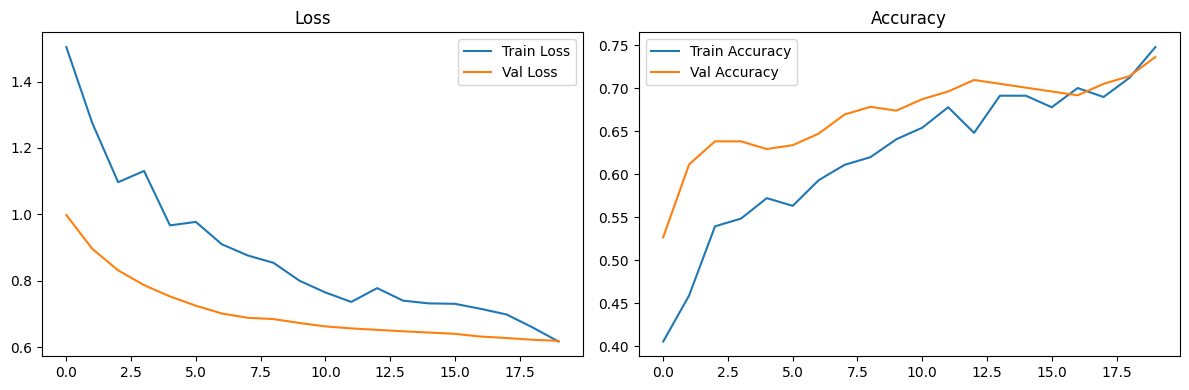

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks

input_dim = train_embs.shape[1]  # Embedding dimensionality

# Define a deeper feedforward neural network with regularization
model = tf.keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),                 # Normalize inputs to improve training
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),                         # Dropout to reduce overfitting
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')        # Output layer for 3-class classification
])

# Compile with smaller learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Stop training early if validation loss does not improve for 3 consecutive epochs
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model with validation
history = model.fit(
    train_embs, y_train.values,
    validation_data=(test_embs, y_test.values),
    epochs=20, batch_size=16,
    callbacks=[early_stop]
)

# Plot training vs. validation loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy')

plt.tight_layout()
plt.show()


A little better, added regularization and less נוירונים

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,819 (386.01 KB)

 Trainable params: 98,819 (386.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5159 - loss: 3.1631 - val_accuracy: 0.7143 - val_loss: 2.2792
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7817 - loss: 2.1091 - val_accuracy: 0.6920 - val_loss: 1.9210
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7929 - loss: 1.7377 - val_accuracy: 0.7455 - val_loss: 1.6458
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7820 - loss: 1.4749 - val_accuracy: 0.7232 - val_loss: 1.4868
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7714 - loss: 1.3582 - val_accuracy: 0.7455 - val_loss: 1.3769
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8173 - loss: 1.1659 - val_accuracy: 0.7500 - val_loss: 1.2717
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8372 - loss: 1.0168 - val_accuracy: 0.7723 - val_loss: 1.2002
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8406 - loss: 0.9675 - val_accuracy: 0.7679 - val_loss

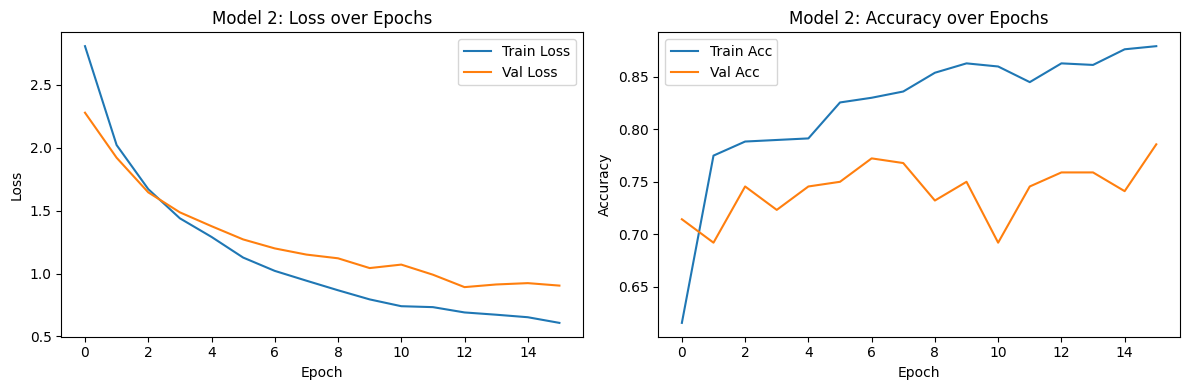

Model 2 Final Test Accuracy: 75.89%


In [17]:
# Cell: Build Model 2 with reduced complexity & stronger regularization (128 neurons)

model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(
        128, activation='relu',
        kernel_regularizer=regularizers.l2(0.01)  # L2 regularization to reduce overfitting
    ),
    tf.keras.layers.Dropout(0.5),                # Strong dropout for regularization
    tf.keras.layers.Dense(
        3, activation='softmax',
        kernel_regularizer=regularizers.l2(0.01)  # Regularization also on output layer
    )
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

# EarlyStopping to prevent overfitting and restore best weights
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

# Train the model and store training history
history2 = model2.fit(
    train_embs, y_train.values,
    validation_data=(test_embs, y_test.values),
    epochs=20,
    batch_size=16,
    callbacks=[early_stop]
)

# Plot training and validation performance
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Model 2: Loss over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.title('Model 2: Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()

# Evaluate final model performance on the test set
test_loss2, test_acc2 = model2.evaluate(test_embs, y_test.values, verbose=0)
print(f"Model 2 Final Test Accuracy: {test_acc2:.2%}")


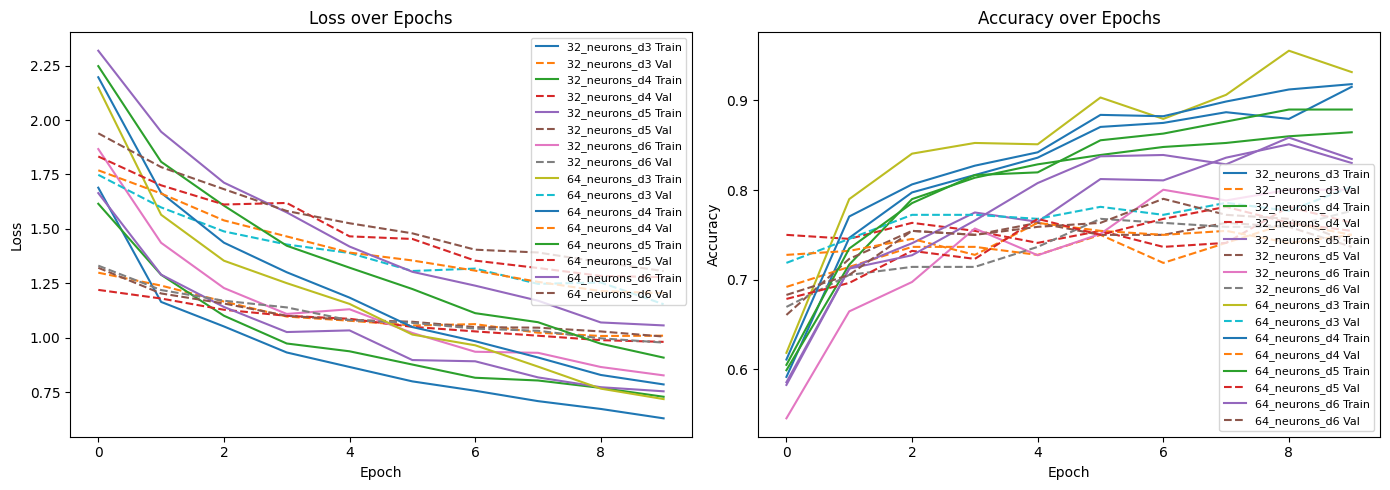

🔎 Final comparison across model configurations:


,Model,Train Acc,Val Acc,Train Loss,Val Loss
4,64_neurons_d3,0.931446,0.803571,0.718311,1.154019
3,32_neurons_d6,0.800298,0.776786,0.827215,0.977733
1,32_neurons_d4,0.864381,0.763393,0.728998,0.981133
6,64_neurons_d5,0.889717,0.754464,0.908776,1.278269
5,64_neurons_d4,0.918033,0.750000,0.785643,1.205009
0,32_neurons_d3,0.915052,0.750000,0.629864,1.009584
7,64_neurons_d6,0.834575,0.741071,1.056739,1.306384
2,32_neurons_d5,0.830104,0.736607,0.754053,1.005494


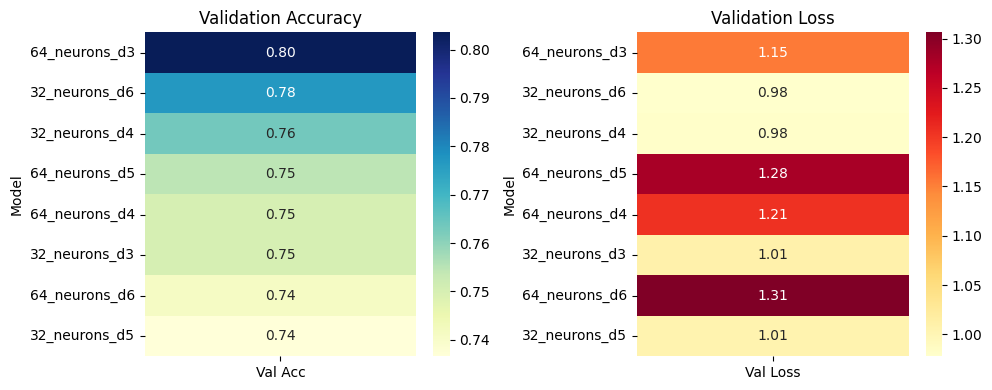

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



neurons_list = [32, 64]
dropouts_list = [0.3, 0.4, 0.5, 0.6]
results = {}
summary_data = []

for n in neurons_list:
    for d in dropouts_list:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(train_embs.shape[1],)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(n, activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dropout(d),
            tf.keras.layers.Dense(3, activation='softmax')
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(train_embs, y_train,
                            validation_data=(test_embs, y_test),
                            epochs=10, batch_size=16, verbose=0)

        label = f"{n}_neurons_d{int(d*10)}"
        results[label] = history.history

        # Save final values to comparison table
        summary_data.append({
            "Model": label,
            "Train Acc": history.history["accuracy"][-1],
            "Val Acc": history.history["val_accuracy"][-1],
            "Train Loss": history.history["loss"][-1],
            "Val Loss": history.history["val_loss"][-1]
        })

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for label, hist in results.items():
    axes[0].plot(hist['loss'], label=f"{label} Train")
    axes[0].plot(hist['val_loss'], linestyle='--', label=f"{label} Val")
axes[0].set_title("Loss over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend(fontsize=8)

for label, hist in results.items():
    axes[1].plot(hist['accuracy'], label=f"{label} Train")
    axes[1].plot(hist['val_accuracy'], linestyle='--', label=f"{label} Val")
axes[1].set_title("Accuracy over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Create and display comparison table
df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values(by="Val Acc", ascending=False)
import seaborn as sns

print("🔎 Final comparison across model configurations:")
display(df_summary)

plt.figure(figsize=(10, 4))

# Heatmap for Val Accuracy
plt.subplot(1, 2, 1)
sns.heatmap(df_summary.set_index("Model")[["Val Acc"]], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Validation Accuracy")

# Heatmap for Val Loss
plt.subplot(1, 2, 2)
sns.heatmap(df_summary.set_index("Model")[["Val Loss"]], annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("Validation Loss")

plt.tight_layout()
plt.show()


###RNN

In [20]:
#  Minimal cleaning: lowercase and remove URLs
def minimal_clean(text):
    t = str(text).lower()
    return re.sub(r'http\S+|www\.\S+', '', t).strip()

df['CleanTitle'] = df['Title'].apply(minimal_clean)

#  Split to train & test with stratification
X_train, X_test, y_train, y_test = train_test_split(
    df['CleanTitle'], df['Label'],
    test_size=0.2, random_state=42, stratify=df['Label']
)

In [21]:
# Load and freeze the HeBERT (AlephBERT) transformer model for use in a TensorFlow pipeline

from transformers import AutoTokenizer, TFAutoModel

# Load tokenizer and pretrained AlephBERT model
tokenizer = AutoTokenizer.from_pretrained("onlplab/alephbert-base")
tf_model = TFAutoModel.from_pretrained("onlplab/alephbert-base", from_pt=True)  # Load PyTorch weights into TF model

tf_model.trainable = False  # Freeze all transformer layers to prevent fine-tuning


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model)

In [22]:
# Prepare a TensorFlow input pipeline and build a model using a frozen AlephBERT encoder

import tensorflow as tf

max_length = 128
batch_size = 16

def encode(texts):
    """
    Tokenize and encode a list of texts using the pretrained tokenizer.

    Returns a dictionary with 'input_ids' and 'attention_mask' tensors.
    """
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

def make_dataset(texts, labels):
    """
    Create a batched tf.data.Dataset of (input_dict, label) pairs.

    Args:
        texts (pd.Series): Input sentences
        labels (pd.Series): Corresponding labels

    Returns:
        tf.data.Dataset: batched dataset for model training/evaluation
    """
    enc = encode(texts.tolist())
    ds = tf.data.Dataset.from_tensor_slices((
        {"input_ids": enc["input_ids"], "attention_mask": enc["attention_mask"]},
        labels
    ))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Prepare training and test datasets
train_ds = make_dataset(X_train, y_train)
test_ds  = make_dataset(X_test, y_test)

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, Lambda

# Define inputs for token IDs and attention masks
inp_ids  = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
inp_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# Use a Lambda layer to extract sequence output (last hidden state) from the frozen transformer
def extract_sequence_outputs(inputs):
    ids, mask = inputs
    return tf_model(ids, attention_mask=mask)[0]  # Only return last_hidden_state

seq_output = Lambda(
    extract_sequence_outputs,
    output_shape=(max_length, tf_model.config.hidden_size)
)([inp_ids, inp_mask])


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    918,528 │ lambda[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256)       │        512 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256)       │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 64)        │     16,448 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 3)         │        195 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 935,683 (3.57 MB)

 Trainable params: 935,683 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 268ms/step - accuracy: 0.5483 - loss: 1.0758 - val_accuracy: 0.6480 - val_loss: 0.7650
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.7514 - loss: 0.5902 - val_accuracy: 0.6872 - val_loss: 0.7283
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.8381 - loss: 0.4536 - val_accuracy: 0.6480 - val_loss: 0.7501
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.8025 - loss: 0.4634 - val_accuracy: 0.7095 - val_loss: 0.7544
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.8606 - loss: 0.3453 - val_accuracy: 0.6927 - val_loss: 0.8809
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.9153 - loss: 0.2462 - val_accuracy: 0.6648 - val_loss: 1.2524


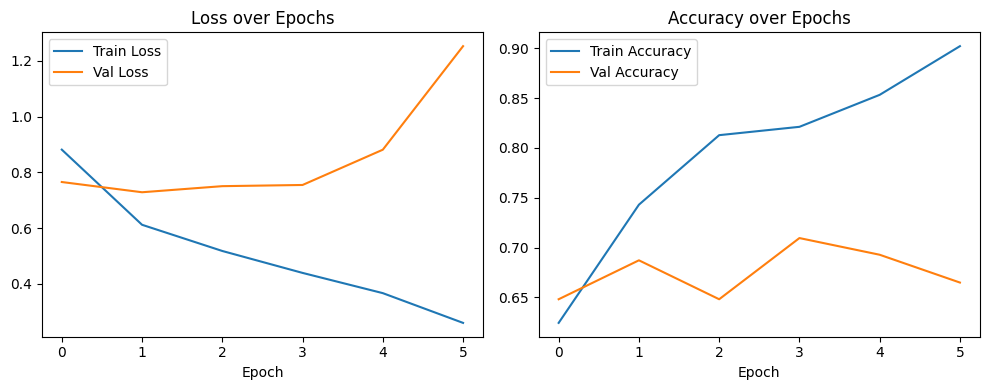

In [23]:
#  Define and train an RNN (BiLSTM) classifier on top of frozen AlephBERT embeddings

# BiLSTM layer over transformer output, followed by normalization and dense layers
x = Bidirectional(LSTM(128))(seq_output)           # Capture contextual features in both directions
x = LayerNormalization()(x)                         # Normalize activations to stabilize training
x = Dropout(0.3)(x)                                 # Regularization
x = Dense(64, activation="relu")(x)                 # Intermediate dense layer
x = Dropout(0.3)(x)
out = Dense(3, activation="softmax")(x)             # Output layer for 3-class classification

# Build and compile the model
rnn_model = Model(inputs=[inp_ids, inp_mask], outputs=out)
rnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
rnn_model.summary()

# Train the model with early stopping based on validation accuracy
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)

history = rnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[es]
)

# Step 5: Plot training and validation performance
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# Plot loss curves
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.legend()

# Plot accuracy curves
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    426,496 │ lambda[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │      8,256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 3)         │        195 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 435,203 (1.66 MB)

 Trainable params: 435,203 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 257ms/step - accuracy: 0.3720 - loss: 1.4891 - val_accuracy: 0.4916 - val_loss: 1.0254
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.5392 - loss: 0.9584 - val_accuracy: 0.5419 - val_loss: 0.9438
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.6067 - loss: 0.8412 - val_accuracy: 0.5363 - val_loss: 0.8946
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.6827 - loss: 0.7255 - val_accuracy: 0.5754 - val_loss: 0.8507
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.7017 - loss: 0.6766 - val_accuracy: 0.6145 - val_loss: 0.8114
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.7274 - loss: 0.6392 - val_accuracy: 0.6480 - val_loss: 0.7872
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.7391 - loss: 0.6124 - val_accuracy: 0.6704 - val_loss: 0.7667
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.7712 - loss: 0.5487 - val_accuracy: 

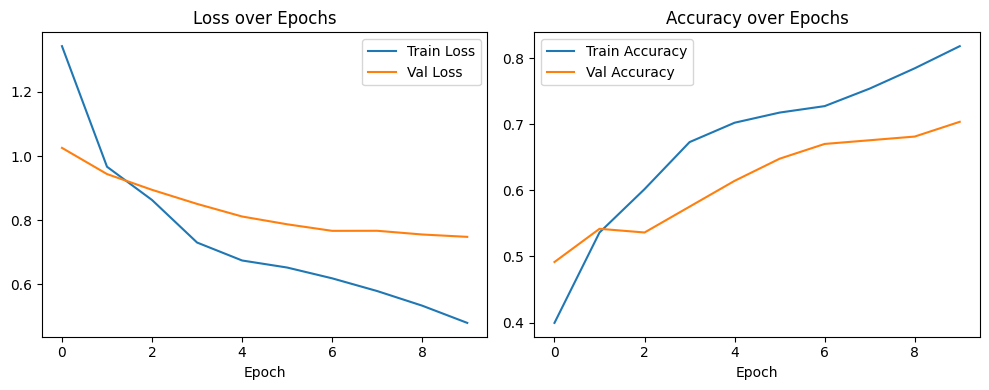

In [24]:
# Define and train a lighter BiLSTM model with stronger regularization and a lower learning rate

# BiLSTM layer with fewer units, followed by normalization and dense head
x = Bidirectional(LSTM(64))(seq_output)              # Smaller recurrent layer
x = LayerNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)                                   # Stronger dropout to reduce overfitting
out = Dense(3, activation="softmax")(x)

rnn_model = Model(inputs=[inp_ids, inp_mask], outputs=out)

# Use low learning rate for stable training on frozen transformer embeddings
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

# Compile model for multiclass classification
rnn_model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

rnn_model.summary()

# Train the model with early stopping based on validation loss
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

history = rnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[es]
)

# Plot training and validation loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()


Training model with LSTM 32 + Dropout 0.3
Training model with LSTM 32 + Dropout 0.4
Training model with LSTM 32 + Dropout 0.5
Training model with LSTM 32 + Dropout 0.6
Training model with LSTM 64 + Dropout 0.3
Training model with LSTM 64 + Dropout 0.4
Training model with LSTM 64 + Dropout 0.5
Training model with LSTM 64 + Dropout 0.6


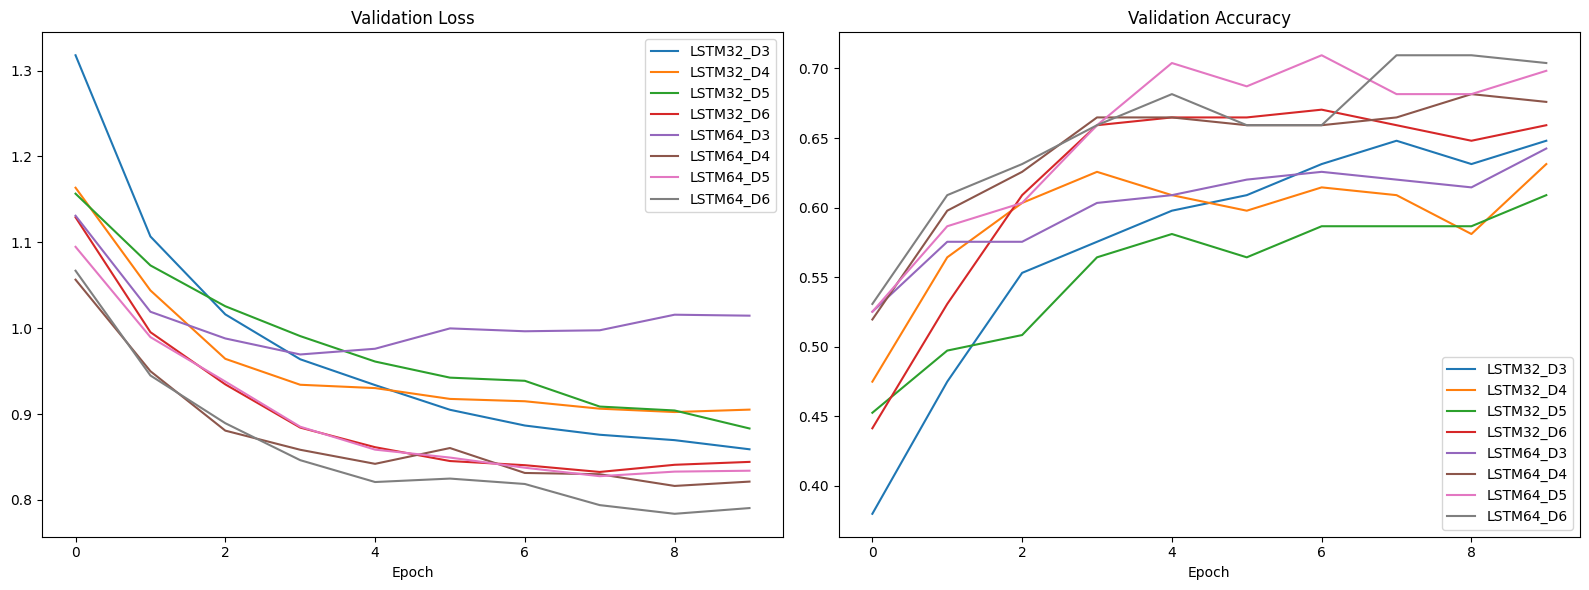

In [25]:
# Grid search over BiLSTM size and dropout rate for model selection on frozen transformer embeddings

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Dictionary to store training history of each configuration
results = {}

# Iterate over different LSTM sizes and dropout rates
for units in [32, 64]:
    for d in [0.3, 0.4, 0.5, 0.6]:
        print(f"Training model with LSTM {units} + Dropout {d}")

        # Define model architecture
        x = Bidirectional(LSTM(units))(seq_output)
        x = Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
        x = LayerNormalization()(x)
        x = Dropout(d)(x)
        out = Dense(3, activation="softmax")(x)

        model = Model(inputs=[inp_ids, inp_mask], outputs=out)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(5e-5),  # Low learning rate for frozen encoder
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        # Train the model quietly (verbose=0)
        history = model.fit(
            train_ds,
            validation_data=test_ds,
            epochs=10,
            batch_size=16,
            verbose=0
        )

        # Store results
        label = f"LSTM{units}_D{int(d*10)}"
        results[label] = history.history

# Plot validation loss and accuracy for all configurations
plt.figure(figsize=(16,6))

# Validation Loss
plt.subplot(1, 2, 1)
for label, hist in results.items():
    plt.plot(hist["val_loss"], label=label)
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.legend()

# Validation Accuracy
plt.subplot(1, 2, 2)
for label, hist in results.items():
    plt.plot(hist["val_accuracy"], label=label)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
# Summarize best performance (highest val accuracy and lowest val loss) for each model configuration

import pandas as pd

rows = []
for name, hist in results.items():
    best_acc = max(hist['val_accuracy'])   # Best validation accuracy across epochs
    best_loss = min(hist['val_loss'])      # Lowest validation loss across epochs
    rows.append((name, best_acc, best_loss))

# Build and sort summary DataFrame
df_results = pd.DataFrame(rows, columns=['Model', 'Best Val Accuracy', 'Lowest Val Loss'])
df_results.sort_values(by='Best Val Accuracy', ascending=False, inplace=True)

# Display sorted results
from IPython.display import display
display(df_results)


,Model,Best Val Accuracy,Lowest Val Loss
6,LSTM64_D5,0.709497,0.827651
7,LSTM64_D6,0.709497,0.783863
5,LSTM64_D4,0.681564,0.816306
3,LSTM32_D6,0.670391,0.832589
0,LSTM32_D3,0.648045,0.858984
4,LSTM64_D3,0.642458,0.969386
1,LSTM32_D4,0.631285,0.902353
2,LSTM32_D5,0.608939,0.883217


###  partial fine- tuning

In [9]:
#  Load AlephBERT and enable fine-tuning only for the last 3 transformer layers

from transformers import AutoTokenizer, TFAutoModel

model_name = "onlplab/alephbert-base"

# Load tokenizer and model (weights from PyTorch)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tf_model = TFAutoModel.from_pretrained(model_name, from_pt=True)

# Freeze the entire transformer model by default
tf_model.trainable = False

# Unfreeze the last 3 encoder layers for partial fine-tuning
for layer in tf_model.bert.encoder.layer[-3:]:
    layer.trainable = True

# Print which layers are trainable
for i, layer in enumerate(tf_model.bert.encoder.layer):
    print(f"Layer {i} trainable: {layer.trainable}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model)

Layer 0 trainable: False
Layer 1 trainable: False
Layer 2 trainable: False
Layer 3 trainable: False
Layer 4 trainable: False
Layer 5 trainable: False
Layer 6 trainable: False
Layer 7 trainable: False
Layer 8 trainable: False
Layer 9 trainable: True
Layer 10 trainable: True
Layer 11 trainable: True


In [10]:
import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Input, Lambda, Bidirectional, LSTM, Dense, Dropout, LayerNormalization
import re

def minimal_clean(text):
    """
    Perform minimal text preprocessing:
    - Lowercase the input
    - Remove URLs
    - Strip surrounding whitespace
    """
    text = str(text).lower()
    return re.sub(r'http\S+|www\.\S+', '', text).strip()

# Clean the text column
df['CleanTitle'] = df['Title'].apply(minimal_clean)

# Split data into train and test sets (with stratification)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['CleanTitle'],
    df['Label'],
    test_size=0.25,
    random_state=42,
    stratify=df['Label']
)

# Define encoding and dataset creation
max_length = 128
batch_size = 16

def encode(texts):
    """
    Tokenize and encode a list of texts using the pretrained tokenizer.
    """
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

def make_dataset(texts, labels):
    """
    Create a batched tf.data.Dataset of ({input_ids, attention_mask}, label) pairs.
    """
    enc = encode(texts.tolist())
    ds = tf.data.Dataset.from_tensor_slices((
        {"input_ids": enc["input_ids"], "attention_mask": enc["attention_mask"]},
        labels
    ))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build TensorFlow datasets for training and evaluation
train_ds = make_dataset(X_train, y_train)
test_ds  = make_dataset(X_test, y_test)

# Define transformer input layers
inp_ids  = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
inp_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# Extract last hidden states from the transformer model using a Lambda wrapper
def extract_sequence_outputs(inputs):
    ids, mask = inputs
    return tf_model(ids, attention_mask=mask)[0]  # Return last_hidden_state

seq_output = Lambda(
    extract_sequence_outputs,
    output_shape=(max_length, tf_model.config.hidden_size)
)([inp_ids, inp_mask])


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [29]:
# Define the classification model on top of partially trainable AlephBERT embeddings

# BiLSTM layer processes the contextual token embeddings
x = Bidirectional(LSTM(64))(seq_output)

# Normalize the output to stabilize training
x = LayerNormalization()(x)

# Regularize and transform with dense layers
x = Dropout(0.3)(x)
x = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)

# Final classification layer for 3 output classes
out = Dense(3, activation="softmax")(x)

# Construct the full model
model = Model(inputs=[inp_ids, inp_mask], outputs=out)


In [30]:
#Compile with low LR for fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
model.summary()


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 128)       │    426,496 │ lambda_1[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ bidirectional_10… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 128)       │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 64)        │      8,256 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 64)        │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 3)         │        195 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 435,203 (1.66 MB)

 Trainable params: 435,203 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Step 5: Train
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[es]
)


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 295ms/step - accuracy: 0.3470 - loss: 2.3401 - val_accuracy: 0.4107 - val_loss: 1.9540
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 207ms/step - accuracy: 0.4023 - loss: 2.1092 - val_accuracy: 0.4688 - val_loss: 1.8575
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.4686 - loss: 2.0212 - val_accuracy: 0.5134 - val_loss: 1.7884
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.5373 - loss: 1.8365 - val_accuracy: 0.5893 - val_loss: 1.7371
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.5589 - loss: 1.7841 - val_accuracy: 0.6116 - val_loss: 1.7026
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.6066 - loss: 1.7568 - val_accuracy: 0.5938 - val_loss: 1.6706
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.5844 - loss: 1.7325 - val_accuracy: 0.6161 - val_loss: 1.6487
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.5976 - loss: 1.6786 - val_accuracy

no overfitting, pretty good model, but not very high accuracy

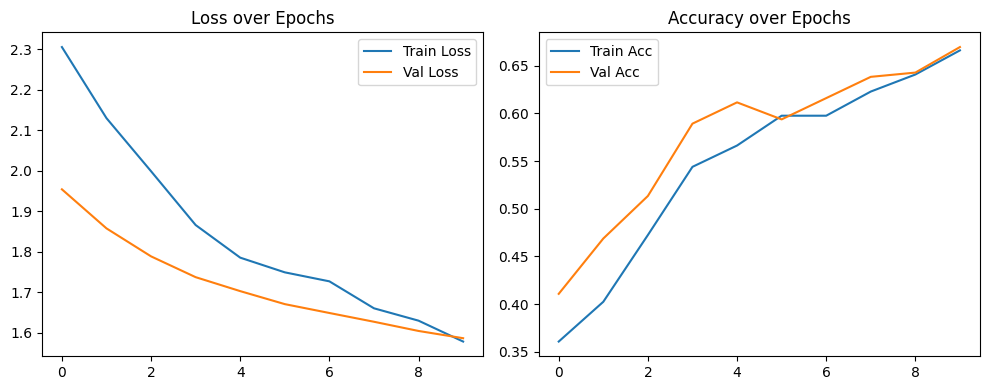

In [32]:
# Step 6: Evaluate
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs"); plt.legend()

plt.tight_layout()
plt.show()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │    426,496 │ lambda[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        195 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 435,203 (1.66 MB)

 Trainable params: 435,203 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 270ms/step - accuracy: 0.3547 - loss: 2.3855 - val_accuracy: 0.3795 - val_loss: 2.0232
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.4153 - loss: 2.1415 - val_accuracy: 0.4911 - val_loss: 1.8981
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.4434 - loss: 2.0230 - val_accuracy: 0.5491 - val_loss: 1.8127
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.4846 - loss: 1.9636 - val_accuracy: 0.5670 - val_loss: 1.7559
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.5074 - loss: 1.8729 - val_accuracy: 0.6161 - val_loss: 1.7072
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.5620 - loss: 1.8144 - val_accuracy: 0.6429 - val_loss: 1.6754
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.6081 - loss: 1.6833 - val_accuracy: 0.6562 - val_loss: 1.6501
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.6441 - loss: 1.6366 - val_accuracy:

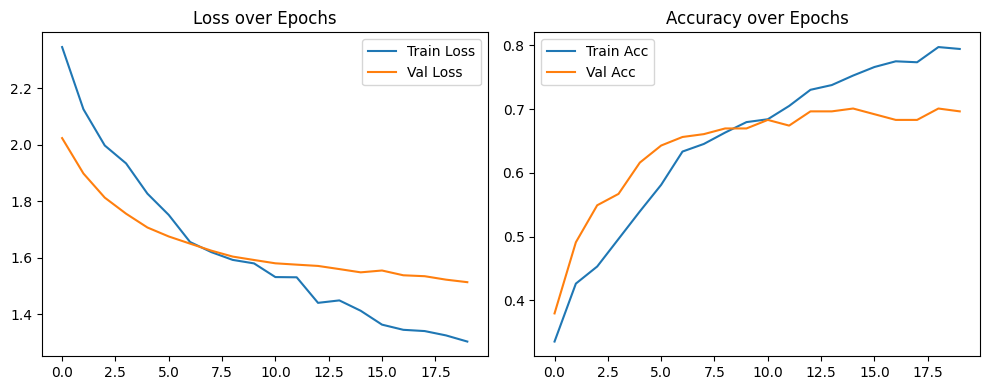

In [11]:
# Define, compile, and train a classification model on partially fine-tuned AlephBERT embeddings

# BiLSTM-based classification head
x = Bidirectional(LSTM(64))(seq_output)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
out = Dense(3, activation="softmax")(x)

# Build the full model
model = Model(inputs=[inp_ids, inp_mask], outputs=out)

# Compile with low learning rate optimizer and sparse categorical loss
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
model.summary()

# Define early stopping to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[es]
)

# Plot training and validation loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 411ms/step - accuracy: 0.3181 - loss: 2.0775 - val_accuracy: 0.3616 - val_loss: 1.4292 - learning_rate: 3.0000e-05
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.3489 - loss: 1.6345 - val_accuracy: 0.3438 - val_loss: 1.2793 - learning_rate: 3.0000e-05
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.3809 - loss: 1.4573 - val_accuracy: 0.3884 - val_loss: 1.2172 - learning_rate: 3.0000e-05
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.4303 - loss: 1.4014 - val_accuracy: 0.4152 - val_loss: 1.1767 - learning_rate: 3.0000e-05
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.4269 - loss: 1.3480 - val_accuracy: 0.4643 - val_loss: 1.1366 - learning_rate: 3.0000e-05
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.4524 - loss: 1.3357 - val_accuracy: 0.4911 - val_loss: 1.1045 - learning_rate: 3.0000e-05
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accura

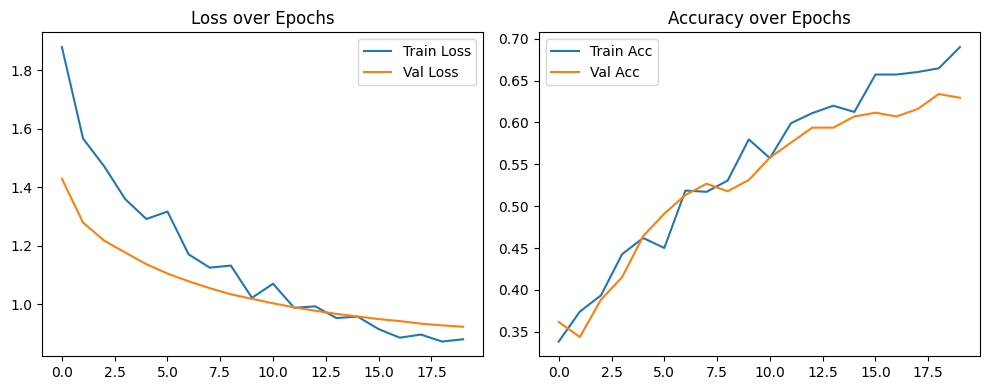

In [33]:
# Define a lightweight classification model using GlobalMaxPooling over frozen AlephBERT outputs

from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, GlobalMaxPooling1D, LayerNormalization

# Define transformer inputs
inp_ids  = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
inp_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# Extract last hidden state from transformer (sequence output)
def extract_sequence_outputs(inputs):
    ids, mask = inputs
    return tf_model(ids, attention_mask=mask)[0]

seq_output = Lambda(
    extract_sequence_outputs,
    output_shape=(max_length, tf_model.config.hidden_size)
)([inp_ids, inp_mask])

# Use GlobalMaxPooling to reduce sequence dimension to fixed-size vector
x = GlobalMaxPooling1D()(seq_output)
x = LayerNormalization()(x)
x = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
out = Dense(3, activation="softmax")(x)

# Build the model
model = Model(inputs=[inp_ids, inp_mask], outputs=out)

# Compile with low learning rate and sparse categorical loss
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

# Define callbacks:
# - Reduce learning rate when val_loss plateaus
# - Early stopping to restore best weights
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[early_stop, lr_schedule]
)

# Plot training and validation performance
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


Training model with LSTM 32 + Dropout 0.3
Training model with LSTM 32 + Dropout 0.4
Training model with LSTM 32 + Dropout 0.5
Training model with LSTM 32 + Dropout 0.6
Training model with LSTM 64 + Dropout 0.3
Training model with LSTM 64 + Dropout 0.4
Training model with LSTM 64 + Dropout 0.5
Training model with LSTM 64 + Dropout 0.6


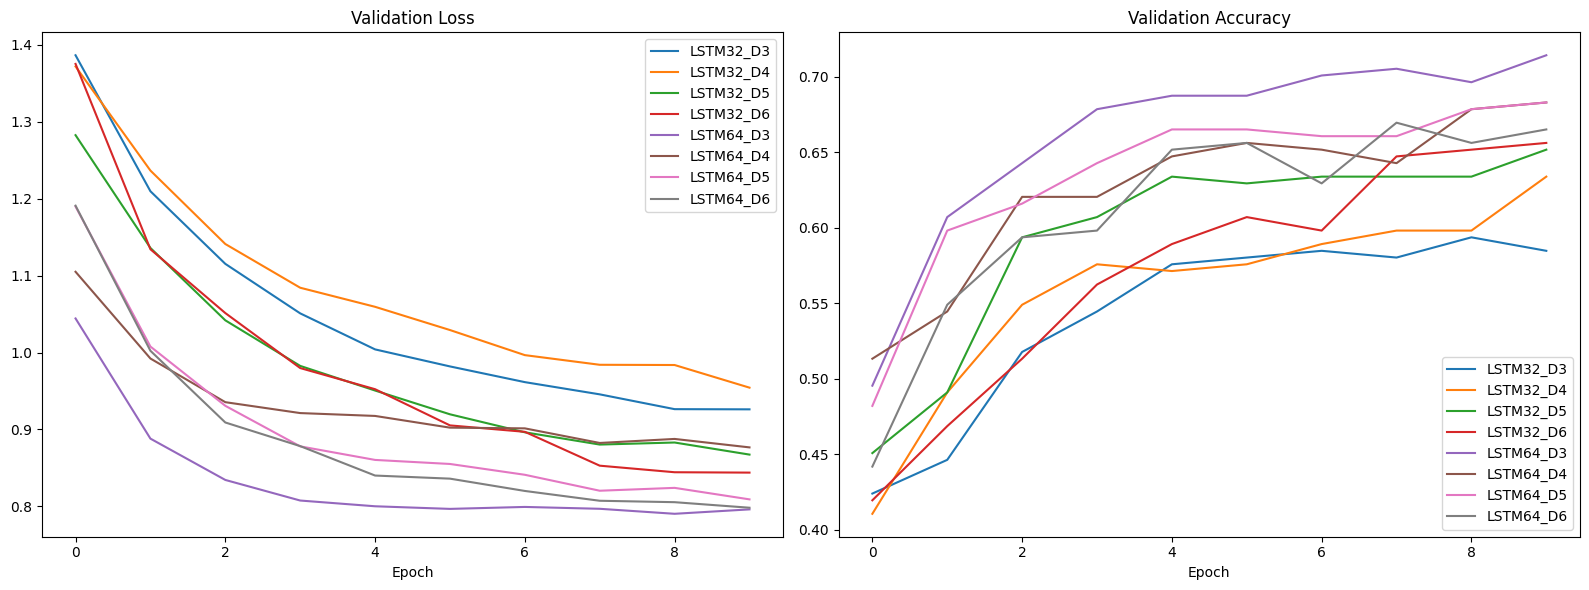

In [34]:
import tensorflow as tf
import matplotlib.pyplot as plt


from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, LayerNormalization, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Dictionary to store training history for each configuration
results = {}

# Try different combinations of LSTM units and dropout rates
for units in [32, 64]:
    for d in [0.3, 0.4, 0.5, 0.6]:
        print(f"Training model with LSTM {units} + Dropout {d}")

        # Define model architecture
        x = Bidirectional(LSTM(units))(seq_output)
        x = Dense(32, activation="relu",kernel_regularizer=regularizers.l2(0.001))(x)
        x = LayerNormalization()(x)
        x = Dropout(d)(x)
        out = Dense(3, activation="softmax")(x)

        model = Model(inputs=[inp_ids, inp_mask], outputs=out)
        model.compile(optimizer=tf.keras.optimizers.Adam(5e-5),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])

        # Train the model silently
        history = model.fit(train_ds,
                            validation_data=test_ds,
                            epochs=10,
                            batch_size=16,
                            verbose=0)

        # Save history for this configuration
        label = f"LSTM{units}_D{int(d*10)}"
        results[label] = history.history


plt.figure(figsize=(16,6))

# Loss
plt.subplot(1,2,1)
for label, hist in results.items():
    plt.plot(hist["val_loss"], label=f"{label}")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
for label, hist in results.items():
    plt.plot(hist["val_accuracy"], label=f"{label}")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
import pandas as pd

rows = []
for name, hist in results.items():
    best_acc = max(hist['val_accuracy'])
    best_loss = min(hist['val_loss'])
    rows.append((name, best_acc, best_loss))

df_results = pd.DataFrame(rows, columns=['Model', 'Best Val Accuracy', 'Lowest Val Loss'])
df_results.sort_values(by='Best Val Accuracy', ascending=False, inplace=True)

from IPython.display import display
display(df_results)


,Model,Best Val Accuracy,Lowest Val Loss
4,LSTM64_D3,0.714286,0.790267
5,LSTM64_D4,0.683036,0.876637
6,LSTM64_D5,0.683036,0.809027
7,LSTM64_D6,0.669643,0.798147
3,LSTM32_D6,0.656250,0.843832
2,LSTM32_D5,0.651786,0.867260
1,LSTM32_D4,0.633929,0.954322
0,LSTM32_D3,0.593750,0.926126


### Full fine- tuning

In [36]:
from transformers import AutoTokenizer, TFAutoModel

model_name = "onlplab/alephbert-base"

# Load the pretrained tokenizer for AlephBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the pretrained AlephBERT model (weights from PyTorch)
bert = TFAutoModel.from_pretrained(model_name, from_pt=True)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

In [37]:
# Print a summary of the overall model architecture
bert.summary()

# Display trainable status for each individual transformer layer
for i, layer in enumerate(bert.bert.encoder.layer):
    print(f"Transformer Layer {i} - trainable: {layer.trainable}")


Model: "tf_bert_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  125976576 
                                                                 
Total params: 125976576 (480.56 MB)
Trainable params: 125976576 (480.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Transformer Layer 0 - trainable: True
Transformer Layer 1 - trainable: True
Transformer Layer 2 - trainable: True
Transformer Layer 3 - trainable: True
Transformer Layer 4 - trainable: True
Transformer Layer 5 - trainable: True
Transformer Layer 6 - trainable: True
Transformer Layer 7 - trainable: True
Transformer Layer 8 - trainable: True
Transformer Layer 9 - trainable: True
Transformer Layer 10 - trainable: True
Transformer Layer 11 - trainable: True


In [38]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Lambda

max_length = 128
batch_size = 16

# Split the data into training and test sets with stratified label distribution
X_train, X_test, y_train, y_test = train_test_split(
    df['CleanTitle'], df['Label'].astype(int), test_size=0.2, stratify=df['Label'], random_state=42
)

# Tokenize and encode input texts
def encode(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

# Create a tf.data.Dataset with input dict and labels
def make_dataset(texts, labels):
    enc = encode(texts)
    ds = tf.data.Dataset.from_tensor_slices((
        {"input_ids": enc["input_ids"], "attention_mask": enc["attention_mask"]},
        labels
    ))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Prepare training and test datasets
train_ds = make_dataset(X_train, y_train)
test_ds  = make_dataset(X_test, y_test)

# Define model inputs
inp_ids  = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
inp_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# Extract the CLS token representation (first token) from transformer output
def extract_CLS(inputs):
    ids, mask = inputs
    output = bert(ids, attention_mask=mask)[0]  # shape: (batch, seq_len, hidden_dim)
    return output[:, 0, :]  # return only CLS token embedding

cls_embedding = Lambda(
    extract_CLS,
    output_shape=(bert.config.hidden_size,)
)([inp_ids, inp_mask])


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 429ms/step - accuracy: 0.3753 - loss: 1.7332 - val_accuracy: 0.4134 - val_loss: 1.2374
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.3577 - loss: 1.5168 - val_accuracy: 0.5028 - val_loss: 1.1277
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.4216 - loss: 1.3222 - val_accuracy: 0.5475 - val_loss: 1.0612
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.4625 - loss: 1.2475 - val_accuracy: 0.5810 - val_loss: 1.0154
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.5196 - loss: 1.1240 - val_accuracy: 0.6034 - val_loss: 0.9797
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.5532 - loss: 1.0447 - val_accuracy: 0.6257 - val_loss: 0.9536
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.6172 - loss: 0.9691 - val_accuracy: 0.6369 - val_loss: 0.9345
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.6308 - loss: 0.9544 - val_accuracy

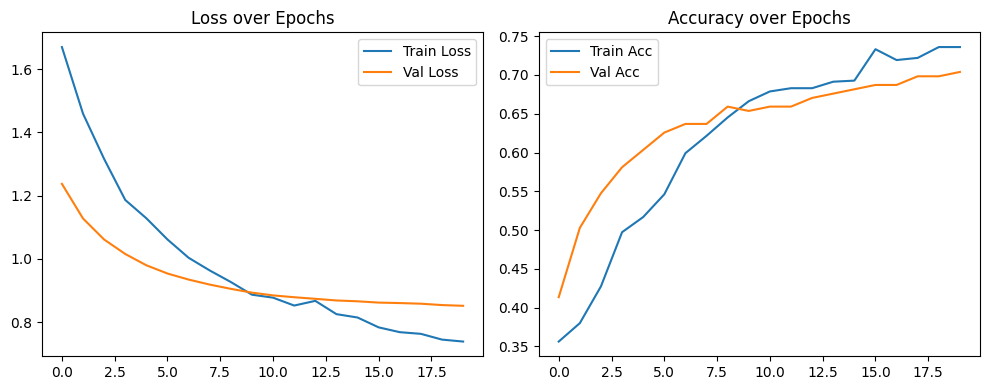

In [39]:
# Classification head using the CLS embedding
x = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001))(cls_embedding)
x = Dropout(0.3)(x)
out = Dense(3, activation="softmax")(x)

# Build the model
model = Model(inputs=[inp_ids, inp_mask], outputs=out)

# Compile the model with low learning rate and appropriate loss
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model.fit(train_ds, validation_data=test_ds, epochs=20, callbacks=[es])

# Plot training and validation loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy over Epochs"); plt.legend()

plt.tight_layout()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Classification Report:


,precision,recall,f1-score,support
0,0.805556,0.500000,0.617021,58.000000
1,0.688312,0.883333,0.773723,60.000000
2,0.666667,0.721311,0.692913,61.000000
accuracy,0.703911,0.703911,0.703911,0.703911
macro avg,0.720178,0.701548,0.694552,179.000000
weighted avg,0.718925,0.703911,0.695410,179.000000


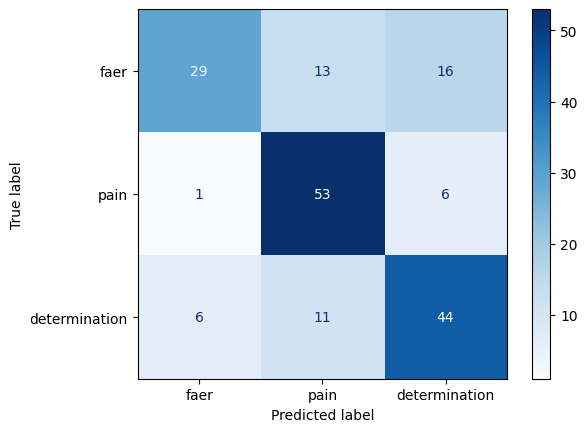

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Encode input texts into token IDs and attention masks
encoded = tokenizer(
    X_test.tolist(),            # List of input texts
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='tf'
)

# Step 2: Predict emotion class probabilities using the trained model
pred_probs = model.predict({
    "input_ids": encoded["input_ids"],
    "attention_mask": encoded["attention_mask"]
})

# Convert predicted probabilities to class indices
y_pred = np.argmax(pred_probs, axis=1)

# Step 3: Prepare ground truth labels
y_true = y_test.astype(int)  # Alternatively: df['Label'].iloc[test_idx]

# Step 4: Generate classification report as a DataFrame
report_dict = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
print("Classification Report:")
display(df_report)

# Step 5: Display confusion matrix
labels = ['faer', 'pain', 'determination']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')


Training model with LSTM 32 + Dropout 0.3
Training model with LSTM 32 + Dropout 0.4
Training model with LSTM 32 + Dropout 0.5
Training model with LSTM 32 + Dropout 0.6
Training model with LSTM 64 + Dropout 0.3
Training model with LSTM 64 + Dropout 0.4
Training model with LSTM 64 + Dropout 0.5
Training model with LSTM 64 + Dropout 0.6


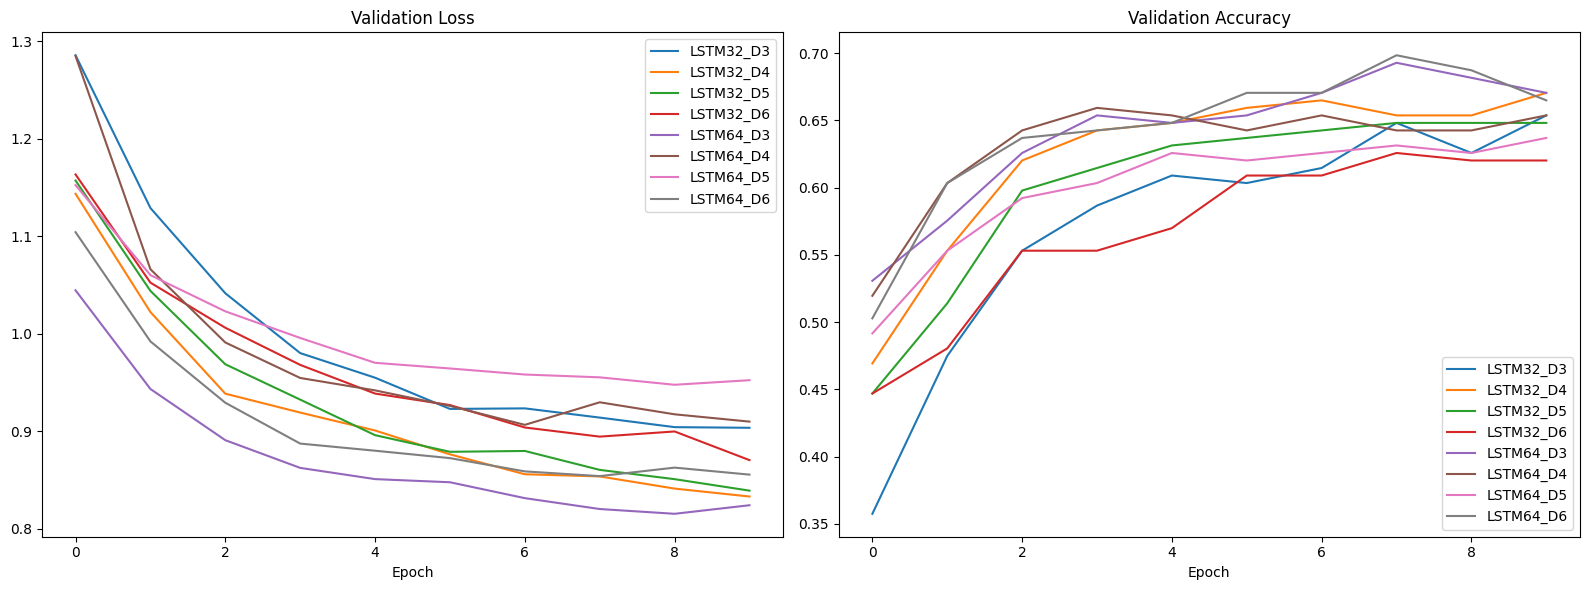

In [43]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, LayerNormalization, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Dictionary to store training history for each configuration
results = {}

# Iterate over combinations of LSTM units and dropout rates
for units in [32, 64]:
    for d in [0.3, 0.4, 0.5, 0.6]:
        print(f"Training model with LSTM {units} + Dropout {d}")

        inp_ids  = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
        inp_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

        # Assume tf_model is already loaded (from TFAutoModel)
        def extract_sequence_outputs(inputs):
            ids, mask = inputs
            return tf_model(ids, attention_mask=mask)[0]

        seq_output = Lambda(
            extract_sequence_outputs,
            output_shape=(max_length, tf_model.config.hidden_size)
        )([inp_ids, inp_mask])

        # BiLSTM + dense classification head
        x = Bidirectional(LSTM(units))(seq_output)
        x = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(x)
        x = LayerNormalization()(x)
        x = Dropout(d)(x)
        out = Dense(3, activation="softmax")(x)

        model = Model(inputs=[inp_ids, inp_mask], outputs=out)
        model.compile(optimizer=tf.keras.optimizers.Adam(5e-5),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])

        # Train model silently
        history = model.fit(train_ds,
                            validation_data=test_ds,
                            epochs=10,
                            verbose=0)

        # Save history for later comparison
        label = f"LSTM{units}_D{int(d*10)}"
        results[label] = history.history

# Plot validation loss and accuracy curves
plt.figure(figsize=(16,6))

# Validation Loss
plt.subplot(1,2,1)
for label, hist in results.items():
    plt.plot(hist["val_loss"], label=f"{label}")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.legend()

# Validation Accuracy
plt.subplot(1,2,2)
for label, hist in results.items():
    plt.plot(hist["val_accuracy"], label=f"{label}")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()


In [44]:
import pandas as pd

rows = []
for name, hist in results.items():
    best_acc = max(hist['val_accuracy'])
    best_loss = min(hist['val_loss'])
    rows.append((name, best_acc, best_loss))

df_results = pd.DataFrame(rows, columns=['Model', 'Best Val Accuracy', 'Lowest Val Loss'])
df_results.sort_values(by='Best Val Accuracy', ascending=False, inplace=True)

from IPython.display import display
display(df_results)


,Model,Best Val Accuracy,Lowest Val Loss
7,LSTM64_D6,0.698324,0.853737
4,LSTM64_D3,0.692737,0.815098
1,LSTM32_D4,0.670391,0.832820
5,LSTM64_D4,0.659218,0.906320
0,LSTM32_D3,0.653631,0.903308
2,LSTM32_D5,0.648045,0.838851
6,LSTM64_D5,0.636872,0.947445
3,LSTM32_D6,0.625698,0.870149


### Examples

In [45]:
def predict_emotion(text):
    # Tokenize and encode the input text
    inputs = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )

    # Extract input tensors (must match the model's input order)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Run prediction (inference mode)
    logits = model([input_ids, attention_mask], training=False)

    # Get the predicted class index
    pred = tf.argmax(logits, axis=1).numpy()[0]

    # Map class index to Hebrew emotion label
    label_map = {0: "פחד", 1: "כאב", 2: "נחישות"}
    return label_map[pred]

# Examples:
print(predict_emotion("חייל נהרג מירי בכניסה לקיבוץ."))
print(predict_emotion("הכוחות ממשיכים בלחימה בנחישות."))
print(predict_emotion("אזעקה הופעלה בירושלים"))
print(predict_emotion("כוחות צהל תקפו באיראן"))
print(predict_emotion("נפילת טיל ברחובות"))


כאב
פחד
פחד
נחישות
פחד


In [46]:
#news from day 29/07/2025


print("ד''ע: צה''ל עצר מחדש מספר מחבלים בעיר קלקיליה ששוחררו בעסקת החטופים האחרונה  ", predict_emotion("ד''ע: צה''ל עצר מחדש מספר מחבלים בעיר קלקיליה ששוחררו בעסקת החטופים האחרונה  "))
print("דיווח: פעילות ותנועת ציוד כבד זוהו באתר הגרעין באיספהאן  ",predict_emotion("דיווח: פעילות ותנועת ציוד כבד זוהו באתר הגרעין באיספהאן  "))
print("אישה נפצעה קל מירי כדור תועה ברחבת הכותל  ",predict_emotion("אישה נפצעה קל מירי כדור תועה ברחבת הכותל  "))
print("חייל מילואים שם קץ לחייו בעקבות פוסט טראומה. עסק במסגרת תפקידו במלאכת זיהוי גופות  ", predict_emotion("חייל מילואים שם קץ לחייו בעקבות פוסט טראומה. עסק במסגרת תפקידו במלאכת זיהוי גופות  "))

ד''ע: צה''ל עצר מחדש מספר מחבלים בעיר קלקיליה ששוחררו בעסקת החטופים האחרונה   נחישות
דיווח: פעילות ותנועת ציוד כבד זוהו באתר הגרעין באיספהאן   פחד
אישה נפצעה קל מירי כדור תועה ברחבת הכותל   כאב
חייל מילואים שם קץ לחייו בעקבות פוסט טראומה. עסק במסגרת תפקידו במלאכת זיהוי גופות   כאב
